# Transfer Learning

## Theory

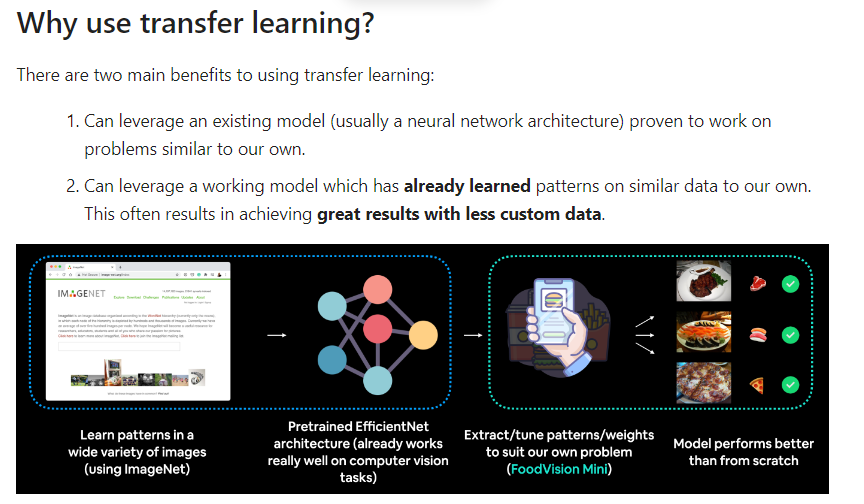

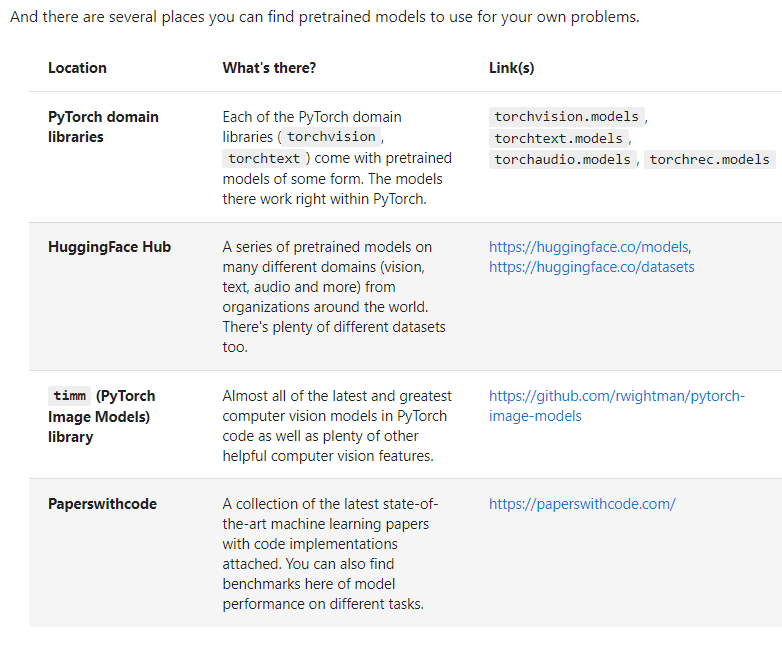

# Modules Settings

In [ ]:
#@title Create classification_ai folder + modules
from pathlib import Path
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -q -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
    # Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
try:
    import torchmetrics
except Exception as e:
    !pip install -q torchmetrics
    import torchmetrics
CLASS_PATH=Path("classification_ai/")
CLASS_PATH.mkdir(parents=True,exist_ok=True)


[INFO] torch/torchvision versions not as required, installing nightly versions.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 89.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%%writefile classification_ai/download_and_decompress_data.py
#@title Download data
import os
import requests
import zipfile
import tarfile
import gzip
from concurrent.futures import ThreadPoolExecutor

def download_file(url, folder='.'):
    file_name = os.path.join(folder, url.split('/')[-1])

    if os.path.exists(file_name):
        return file_name  # Return file path if it already exists

    print(f"Downloading {url}")
    response = requests.get(url, stream=True)

    with open(file_name, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)

    print(f"Download complete: {file_name}")
    return file_name

def decompress_file(file_name):
    if file_name.endswith('.zip'):
        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            zip_ref.extractall(os.path.dirname(file_name))
        os.remove(file_name)
    elif file_name.endswith('.tar.gz') or file_name.endswith('.tgz'):
        with tarfile.open(file_name, 'r:gz') as tar_ref:
            tar_ref.extractall(os.path.dirname(file_name))
        os.remove(file_name)
    elif file_name.endswith('.gz'):
        with gzip.open(file_name, 'rb') as gz_ref:
            with open(file_name[:-3], 'wb') as uncompressed_file:
                uncompressed_file.write(gz_ref.read())
        os.remove(file_name)

def is_already_downloaded_or_decompressed(url, folder):
    file_name = os.path.join(folder, url.split('/')[-1])
    decompressed_file_name = file_name

    if file_name.endswith('.zip'):
        decompressed_file_name = file_name[:-4]
    elif file_name.endswith('.tar.gz') or file_name.endswith('.tgz'):
        decompressed_file_name = file_name[:-7]
    elif file_name.endswith('.gz'):
        decompressed_file_name = file_name[:-3]

    return os.path.exists(file_name) or os.path.exists(decompressed_file_name)

def download_and_decompress(url, folder='.'):
    if not os.path.exists(folder):
        os.makedirs(folder)

    if is_already_downloaded_or_decompressed(url, folder):
        print(f"{url} was already downloaded and decompressed in {folder}.")
        return

    with ThreadPoolExecutor(max_workers=2) as executor:
        file_name = executor.submit(download_file, url, folder).result()

        if file_name:
            print(f"Downloaded {file_name} successfully.")
            executor.submit(decompress_file, file_name)
            print(f"Decompressed {file_name}.")
        else:
            print(f"Failed to download {url}.")

#download_and_decompress("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip","data")




Writing classification_ai/download_and_decompress_data.py


In [ ]:
#@title Delete Data Folder
#!rm -rf data



In [ ]:
%%writefile classification_ai/data_setup.py
#@title Data set up

"""
Contains functionality for creating PyTorch DataLoaders for
image classification data.
"""
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    data: str,
    transform: transforms.Compose,
    batch_size: int,
    train_test_ratio: float,
    num_workers: int=NUM_WORKERS,
):
  """Creates DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    data: path to directory of data (food-101)
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    train_test_ratio: Percentage of data you want to be TEST data.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A dataloader.
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(data=path/to/food-101,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=os.cpu_count())
  """
  # Use ImageFolder to create dataset(s)
  data = datasets.ImageFolder(data, transform=transform)
  train_data, test_data = random_split(data,[1-train_test_ratio, train_test_ratio])
  # Get class names
  class_names = data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names


Writing classification_ai/data_setup.py


# Model Settings

In [ ]:
#@title Device Agnostic
device="cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#@title Model+Weights (EfficientNetB0 model). Original with no changes.

#weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT # .DEFAULT = best available weights
#model_1 = torchvision.models.efficientnet_b1(weights=weights).to(device)
weights = torchvision.models.ResNet50_Weights.DEFAULT # .DEFAULT = best available weights
model_1 = torchvision.models.resnet50(weights=weights)
# To get a summary via torchinfo
summary(model=model_1,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [ ]:
#@title Set Up Data + Transform given chossen model
from classification_ai.download_and_decompress_data import download_and_decompress
from classification_ai.data_setup import create_dataloaders

#Download
download_and_decompress("http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz","data")

#We could either set it by hand, via consulting the model's documentation and stuff, or get it directly
#Transform
auto_transform = weights.transforms()


#DataLoaders
train_dataloader, test_dataloader, class_names = create_dataloaders(data=r"data/food-101/images",transform=auto_transform,batch_size=32,train_test_ratio=0.5)

Download complete: data/food-101.tar.gz
Downloaded data/food-101.tar.gz successfully.
Decompressed data/food-101.tar.gz.


In [ ]:
#@title Freezing pretrained layers (features parameters), changing output layer to our problem

"""# To freeze, just say required_grad=False

for param in model_1.features.parameters():
  param.requires_grad = False
#Ajust output layer of classifier. Here we keep nn.Drouput and just change output of nn.Linear
model_1.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,out_features=len(class_names))
).to(device)

#New summary
# To get a summary via torchinfo
summary(model=model_1,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])"""
for param in model_1.parameters():
    param.requires_grad = False
model_1.fc  =  nn.Linear(in_features=2048,out_features=len(class_names)).to(device)

summary(model=model_1,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 101]            --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

# Testing the Model

In [ ]:
#@title Train the model
%%time
EPOCHS = 4 # @param {type:"integer"}
LEARNING_RATE = 0.01 # @param {type:"number"}
def multiclass_classification_training(model,train_dataloader,test_dataloader,learning_rate,out_shape=10,epochs=2,batches=0):
  MODEL_NAME = "food_classifier_101_ResNet" # @param {type:"string"}
  # Set up metrics
  from tqdm.auto import tqdm
  import torch
  from torch import nn
  from google.colab import drive
  drive.mount('drive/')
  import os
  from pathlib import Path
  #set loss
  loss_fn = nn.CrossEntropyLoss()
  #set optimizer
  optimizer = torch.optim.Adam(params=model.parameters(),
                              lr=learning_rate)
  # proporcion of correct predictions
  accuracy_fn = torchmetrics.Accuracy(task="multiclass",num_classes=out_shape).to(device)
  # proporcion of predicted positives that are actually positives:  "Out of all the instances the model classified as positive, how many were truly positive?"
  precision_fn = torchmetrics.Precision(task="multiclass",num_classes=out_shape).to(device)
  # proporcion of actual positives that are correctly predicted: "Out of all the truly positive instances in the data, how many did the model correctly identify?
  recall_fn = torchmetrics.Recall(task="multiclass",num_classes=out_shape).to(device)
  # f1: Combines precision and accuracy. Closer to 1 is better
  f1_fn = torchmetrics.F1Score(task="multiclass",num_classes=out_shape).to(device)

  #@title Test Model
  # Set seeds
  torch.manual_seed(44)
  torch.cuda.manual_seed(44)


  # Loop through epochs

  for epoch in tqdm(range(epochs)):
      print(f"Epoch {epoch+1}:\n-----------------------------")
      ### Training
      model_1.train()

      # Initialize metrics for training data
      train_loss, train_accuracy, train_precision, train_recall, train_f1 = 0, 0, 0, 0, 0

      # Loop through training batches
      for batch, (X, y) in enumerate(train_dataloader):
          model_1.train()
          X=X.to(device)
          y=y.to(device)
          # 1. Forward Pass
          y_logits = model_1(X)
          y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
          # 2. Loss and metrics for batched data
          loss = loss_fn(y_logits, y)
          train_loss += loss

          accuracy = accuracy_fn(y_preds, y) * 100
          train_accuracy += accuracy

          precision = precision_fn(y_preds, y) * 100
          train_precision += precision

          recall = recall_fn(y_preds, y) * 100
          train_recall += recall

          f1 = f1_fn(y_preds, y)
          train_f1 += f1
          batches+=1
          # 3. Optimizer zero grad
          optimizer.zero_grad()

          # 4. Loss backward, i.e., backpropagation = calculate gradient
          loss.backward()

          # 5. Optimizer step
          optimizer.step()

          # Print some output
          if batch % (len(train_dataloader)/3)== 0 or batch+1==len(train_dataloader):
              print(f"Looked at {(batch+1) * len(X)}/{len(train_dataloader.dataset)} samples")

      # Average metrics per epoch
      train_loss = train_loss/len(train_dataloader)
      train_accuracy = train_accuracy/len(train_dataloader)
      train_precision = train_precision/len(train_dataloader)
      train_recall = train_recall/len(train_dataloader)
      train_f1 = train_f1/len(train_dataloader)

      ### Testing
      test_loss, test_accuracy, test_precision, test_recall, test_f1 = 0, 0, 0, 0, 0
      model_1.eval()

      with torch.inference_mode():
          for X, y in test_dataloader:
              X=X.to(device)
              y=y.to(device)
              # 1. Forward pass
              y_logits_test = model_1(X)
              y_preds_test = torch.softmax(y_logits_test, dim=1).argmax(dim=1)

              # 2. Calculate metrics for the test
              loss_t = loss_fn(y_logits_test, y)
              test_loss += loss_t

              # Metrics by batch
              accuracy_t = accuracy_fn(y_preds_test, y) * 100
              test_accuracy += accuracy_t

              precision_t = accuracy_fn(y_preds_test, y) * 100
              test_precision += precision_t

              recall_t = recall_fn(y_preds_test, y) * 100
              test_recall += recall_t

              f1_t = f1_fn(y_preds_test, y)
              test_f1 += f1_t
      # Average metrics per epoch
      test_loss = test_loss/len(test_dataloader)
      test_accuracy = test_accuracy/len(test_dataloader)
      test_precision = test_precision/len(test_dataloader)
      test_recall = test_recall/len(test_dataloader)
      test_f1 = test_f1/len(test_dataloader)
      print(f"| Loss: {train_loss:.5f}, Acc: {train_accuracy:.2f}%, Pre: {train_precision:.2f}%, Recall: {train_recall:.2f}%, F1: {train_f1:.4}")
      print(f"| TestLoss: {test_loss:.5f}, TestAcc: {test_accuracy:.2f}%, TestPre: {test_precision:.2f}%, TestRecall: {test_recall:.2f}%, TestF1: {test_f1:.4}")
      print(f"| Number of executed batches of size {train_dataloader.batch_size}: {batches}")
      print(f"--------------------------------------------------------------------------------------------------------")

      if epoch % 1 ==0 or epoch+1==epochs:
        # 1. Create models directory
        MODEL_PATH = Path("drive/MyDrive/Models")
        MODEL_PATH.mkdir(parents=True, exist_ok=True)

        COURSE_PATH = MODEL_PATH / "Course"
        COURSE_PATH.mkdir(parents=True, exist_ok=True)

        # 2. Create model save path
        MODEL_NAME = MODEL_NAME + ".pth"
        MODEL_SAVE_PATH = COURSE_PATH / MODEL_NAME

        # 3. Check if the model with the same name exists, and delete it if it does
        existing_model_path = COURSE_PATH / MODEL_NAME
        if existing_model_path.exists():
            print(f"Deleting existing model at: {existing_model_path}")
            os.remove(existing_model_path)

        # 4. Save the model state dict()
        print(f"Saving model to: {MODEL_SAVE_PATH}")
        torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

multiclass_classification_training(model=model_1,train_dataloader=train_dataloader,test_dataloader=test_dataloader,learning_rate=LEARNING_RATE,out_shape=len(class_names),epochs=EPOCHS)


Mounted at drive/


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:
-----------------------------
Looked at 32/50500 samples
Looked at 6316/50500 samples
| Loss: 2.80587, Acc: 44.12%, Pre: 44.12%, Recall: 44.12%, F1: 0.4412
| TestLoss: 2.54169, TestAcc: 51.72%, TestPre: 51.72%, TestRecall: 51.72%, TestF1: 0.5172
| Number of executed batches of size 32: 1579
--------------------------------------------------------------------------------------------------------
Saving model to: drive/MyDrive/Models/Course/food_classifier_101_ResNet.pth
Epoch 2:
-----------------------------
Looked at 32/50500 samples
Looked at 6316/50500 samples
| Loss: 2.04147, Acc: 59.30%, Pre: 59.30%, Recall: 59.30%, F1: 0.593
| TestLoss: 2.98180, TestAcc: 51.98%, TestPre: 51.98%, TestRecall: 51.98%, TestF1: 0.5198
| Number of executed batches of size 32: 3158
--------------------------------------------------------------------------------------------------------
Saving model to: drive/MyDrive/Models/Course/food_classifier_101_ResNet.pth.pth
Epoch 3:
------------------------

In [ ]:
#@title Load Previously Trained Model
# To load in a saved state_dcit we have to instantiate a new instance of our model class!
MODEL_PATH = Path("drive/MyDrive/Models")
COURSE_PATH = MODEL_PATH / "Course"
MODEL_NAME= "food_classifier_101" # @param {type:"string"}
MODEL_NAME = MODEL_NAME+".pth"
MODEL_SAVE_PATH = COURSE_PATH / MODEL_NAME
#Load the saved state_dict of model_0, this will update the new isntance with updated parameters!
model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

Reality:


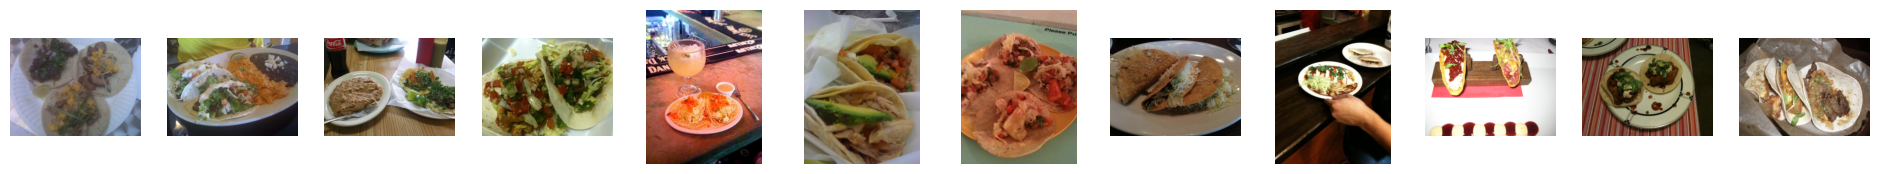


Prediction:
['tacos', 'huevos_rancheros', 'hamburger', 'beet_salad', 'ramen', 'tacos', 'tacos', 'foie_gras', 'tacos', 'foie_gras', 'sushi', 'tacos']


In [ ]:
#@title Prediction VS Reality with numbers dataset

from IPython.display import display, HTML, clear_output
import io
from PIL import Image
import ipywidgets as widgets
import numpy as np
import torch

# Initialize image_array_list as an empty list globally
image_array_list = []
images=[]

# Function to handle the uploaded images and display them
def on_upload_change(change):
    global image_array_list  # Declare image_array_list as a global variable
    global image_array2
    clear_output(wait=True)
    uploaded_files = upload_button.value
    if uploaded_files:
        # Iterate through the uploaded files
        for file_name, file_info in uploaded_files.items():
            image = Image.open(io.BytesIO(file_info['content']))
            # Convert the image to a NumPy array
            image_array2=np.array(image)
            images.append(image_array2)
            image_array = auto_transform(image).to(device)
            image_array_list.append(image_array)
            # Display the image
    else:
        print("No files uploaded.")

# Create a file upload button
upload_button = widgets.FileUpload(description="Upload Images", accept=".jpg,.jpeg,.png", multiple=True)
upload_button.observe(on_upload_change, names='value')

# Display the file upload button
display(upload_button)

# Create a button for comparison
compare_button = widgets.Button(description="Compare Images")

# Function to handle the comparison
def on_compare_button_click(b):
    clear_output(wait=True)
    print("Reality:")
    # Display all uploaded images
    num_images = len(image_array_list)
    if num_images == 1:
        # Handle the case of a single image separately
        plt.figure(figsize=(2, 2))

        plt.imshow(image_array2, cmap='gray')
        plt.axis('off')
        plt.show()
    else:
        # Display all uploaded images side by side
        figsizes=[(2,2)]*len(image_array_list)
        fig, axes = plt.subplots(1, num_images, figsize=(sum(figsizes[i][0] for i in range(num_images)), max(figsizes[i][1] for i in range(num_images))))

        for i, image in enumerate(images):
            axes[i].imshow(image, cmap='gray')
            axes[i].axis('off')

    plt.show()
    # Perform predictions for each image
    print("\nPrediction:")
    predictions=[]
    for image_array in image_array_list:
        image_array_tensor = torch.Tensor(image_array).unsqueeze(dim=0).type(torch.float).to(device)
        with torch.inference_mode():
            prediction_logits = model_1(image_array_tensor)
        prediction_probs = torch.softmax(prediction_logits, dim=1)
        prediction_pred = prediction_probs.argmax().item()
        label=class_names[prediction_pred]
        predictions.append(label)
    print(f"{predictions}")

# Assign the function to the button click event
compare_button.on_click(on_compare_button_click)

# Display the compare button
display(compare_button)
